In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf


### Dataset

In [44]:
# Training Flags (hyperparameter configuration)
model_name = 'ppca'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']
height = 28
width = 28
x_dim = height * width
z_dim = 2

In [45]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [46]:
X = train_images.reshape([-1, x_dim])
print(X.shape)

X_indexes = np.random.randint(0, len(X), 1000)
X = X[X_indexes][:, :, None]
print(X.shape)

t = train_labels[X_indexes]
print(t.shape)

(60000, 784)
(1000, 784, 1)
(1000,)


### Expectation & Maximization Functions Implementation

In [47]:
from numpy.linalg import inv

def get_M(W, variance):
    return W.T @ W + variance * np.eye(z_dim)

def get_z_mean(M_inv, W, x, x_mean):
    z_mean = M_inv @ W.T @ (x - x_mean)
    
    return z_mean

def get_z_cov(variance, M_inv, z_mean):
    return variance * M_inv + z_mean @ z_mean.T

def E_step(W, variance, X, x_mean):
    M = get_M(W, variance)
    M_inv = inv(M)
    
    z_means = []
    z_covs = []
    for i in range(len(X)):
        z_mean = get_z_mean(M_inv, W, X[i], x_mean)
        z_cov = get_z_cov(variance, M_inv, z_mean)
        z_means.append(z_mean)
        z_covs.append(z_cov)
    
    z_means = np.stack(z_means)
    z_covs = np.stack(z_covs)
    
    return z_means, z_covs

def get_W_new(X, x_mean, z_means, z_covs):
    # X: [N, x_dim, 1]
    # x_mean: [x_dim, 1]
    # z_means: [N, z_dim, 1]
    # z_covs: [N, z_dim, z_dim]
    
    a = np.zeros([x_dim, z_dim])
    for n in range(len(X)):
        a += (X[n] - x_mean) @ z_means[n].T
        
    b = np.zeros([z_dim, z_dim])
    for n in range(len(X)):
        b += z_covs[n]
        
    b = inv(b)
    
    return a @ b

def get_variance_new(X, x_mean, z_means, z_covs, W_new):
    # X: [N, x_dim, 1]
    # x_mean: [dim, 1]
    # z_means: [N, z_dim, 1]
    # z_covs: [N, z_dim, z_dim]
    # W_new: [x_dim, z_dim]
    
    for n in range(len(X)):
        a = np.linalg.norm(X[n] - x_mean[:, 0], ord=2)
        b = 2 * z_means[n].T @ W_new.T @ (X[n] - x_mean)
        c = np.trace(z_covs[n] @ W_new.T @ W_new)
        variance_new = np.sum(a - b + c) / (len(X) * x_dim)
        
        return variance_new
    
def M_step(X, x_mean, z_means, z_covs):
    # X: [N, x_dim, 1]
    # x_mean: [x_dim, 1]
    # z_means: [N, z_dim, 1]
    # z_covs: [N, z_dim, z_dim]
    
    W_new = get_W_new(X, x_mean, z_means, z_covs)
    variance_new = get_variance_new(X, x_mean, z_means, z_covs, W_new)
    
    return W_new, variance_new    

In [ ]:
W = np.random.randn(x_dim, z_dim) * 0.01
variance = 0.01

x_mean = np.mean(X, axis=0)
 
for step in range(100):
    print(step, 'step')
    z_means, z_covs = E_step(W, variance, X, x_mean)
    W, variance = M_step(X, x_mean, z_means, z_covs)

### Plotting

In [49]:
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

### Z-embedding Results

(1000, 2)


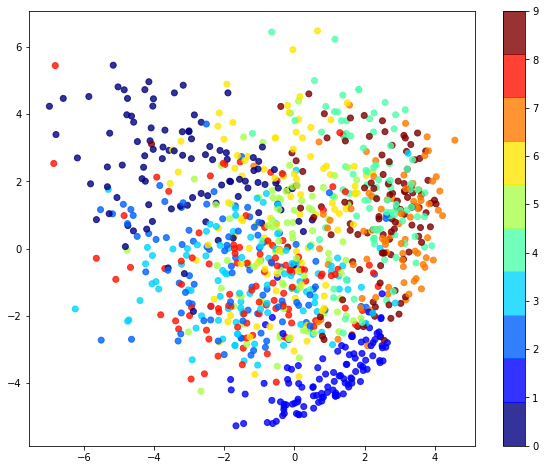

In [50]:
from numpy.linalg import inv

M = W.T @ W + variance * np.eye(z_dim)
M_inv = inv(M)

Z = []
labels = []
for index in range(0, len(X)):
    x = X[index]
    z = M_inv @ W.T @ (x - x_mean)
    Z.append(z[:, 0])
    labels.append(t[index])
    
Z = np.stack(Z)
labels = np.stack(labels)

print(Z.shape)

plt.figure(figsize=[10, 8])
plt.scatter(Z[:, 0], Z[:, 1], c=labels, cmap=discrete_cmap(10, 'jet'), alpha=0.8)
plt.colorbar()
plt.show()

### Interpolation Z-vectors

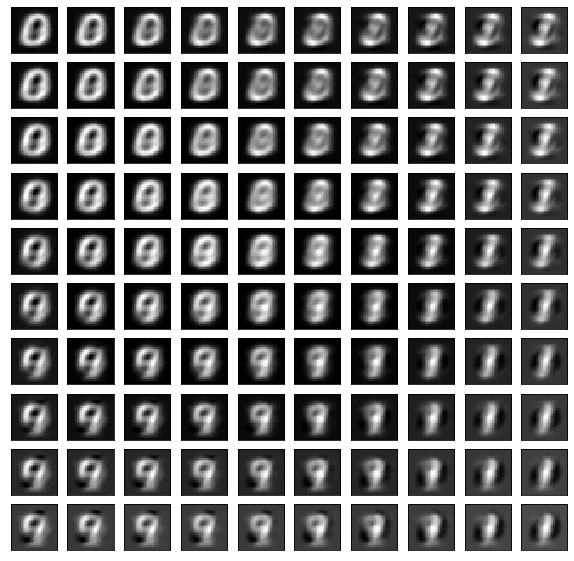

In [51]:
x_grid = np.linspace(-4, 4, 10)
y_grid = np.linspace(4, -4, 10)
xv, yv = np.meshgrid(x_grid, y_grid)
Z = np.stack([xv, yv], axis=2)

plt.figure(figsize=[10, 10])
for x_index in range(10):
    for y_index in range(10):
        z = Z[x_index][y_index][:, None]
        x = (W @ z + x_mean)[:, 0]
        
        plt.subplot(10, 10, x_index + 1 + y_index * 10)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(x.reshape((height, width)), cmap='gray')
        
plt.show()
        